<a href="https://colab.research.google.com/github/demelere/News-Classification/blob/master/458_Assignment_3b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A. Setup

In [1]:
import numpy as np
import pandas as pd
import os
from collections import Counter
import datetime
import copy

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import reuters
from tensorflow.keras import preprocessing
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding, SimpleRNN, LSTM, Conv1D, MaxPooling1D

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
keras.__version__

'2.4.0'

In [3]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

## B. Data import

In [4]:
# Restrict data to the 10000 most frequent words in the data
voc_size = 10000

(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=voc_size)

2113536/2110848 [==============================] - 0s 0us/step


In [5]:
len(train_data), len(train_labels), len(test_data), len(test_labels)

(8982, 8982, 2246, 2246)

In [6]:
print(train_data[1]) 

[1, 3267, 699, 3434, 2295, 56, 2, 7511, 9, 56, 3906, 1073, 81, 5, 1198, 57, 366, 737, 132, 20, 4093, 7, 2, 49, 2295, 2, 1037, 3267, 699, 3434, 8, 7, 10, 241, 16, 855, 129, 231, 783, 5, 4, 587, 2295, 2, 2, 775, 7, 48, 34, 191, 44, 35, 1795, 505, 17, 12]


In [7]:
max([len(set(lst)) for lst in train_data])

530

In [8]:
# Use the reuters.get_word_index method to return a dictionary to translate indices to words
word_index = reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
decoded_newswire = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[1]])
decoded_newswire

557056/550378 [==============================] - 0s 0us/step


'? generale de banque sa lt ? br and lt heller overseas corp of chicago have each taken 50 pct stakes in ? company sa ? factors generale de banque said in a statement it gave no financial details of the transaction sa ? ? turnover in 1986 was 17 5 billion belgian francs reuter 3'

In [9]:
# Number of words in the document
len(decoded_newswire.split()) 

56

In [10]:
# First 7 words in the document
decoded_newswire.split()[:7]

['?', 'generale', 'de', 'banque', 'sa', 'lt', '?']

In [11]:
# The list of encodings is the same size as the number of words in the document
len(train_data[1])

56

In [12]:
train_data[1][:7] # The encodings of the first 7 words in the document. Again, 2 = "unknown"

[1, 3267, 699, 3434, 2295, 56, 2]

In [13]:
len(Counter(list(train_labels)).keys()) # There are 46 topics

46

In [14]:
# The ten most common train labels
from collections import Counter
train_label_tuples = \
Counter(list(train_labels)).most_common(10) # if we keep the top nine we get the same training and test labels
train_label_tuples

[(3, 3159),
 (4, 1949),
 (19, 549),
 (16, 444),
 (1, 432),
 (11, 390),
 (20, 269),
 (13, 172),
 (8, 139),
 (10, 124)]

In [15]:
# The ten most common test labels
from collections import Counter
test_label_tuples = \
Counter(list(test_labels)).most_common(10) # if we keep the top 9 we get the same training and test labels
test_label_tuples

[(3, 813),
 (4, 474),
 (19, 133),
 (1, 105),
 (16, 99),
 (11, 83),
 (20, 70),
 (8, 38),
 (13, 37),
 (25, 31)]

In [16]:


# Separate the the labels from their frequencies
topics_train_tpl, train_freq = zip(*Counter(list(train_labels)).most_common(9))
topics_train_tpl

(3, 4, 19, 16, 1, 11, 20, 13, 8)

In [17]:
train_freq

(3159, 1949, 549, 444, 432, 390, 269, 172, 139)

In [18]:
topics_test_tpl, test_freq = zip(*Counter(list(test_labels)).most_common(9))
topics_test_tpl

(3, 4, 19, 1, 16, 11, 20, 8, 13)

In [19]:
sum(test_freq) # number of test values in top 10

1852

In [20]:
sum(train_freq)  # number of training values in top 10

7503

In [21]:
train_data_sm, train_labels_sm = zip(*((x,y) for x,y in zip(train_data,train_labels) if y in topics_train_tpl))

In [22]:
train_data_sm, train_labels_sm = np.array(train_data_sm), np.array(train_labels_sm)

In [23]:
len(train_data_sm), len(train_labels_sm)  # matches number of training values in top 10

(7503, 7503)

In [24]:
test_data_sm, test_labels_sm = zip(*((x,y) for x,y in zip(test_data,test_labels) if y in topics_test_tpl))

In [25]:
test_data_sm, test_labels_sm = np.array(test_data_sm), np.array(test_labels_sm)

In [26]:
len(test_data_sm), len(test_labels_sm) # matches number of test values in top 10

(1852, 1852)

In [27]:
Counter(train_labels_sm)

Counter({1: 432,
         3: 3159,
         4: 1949,
         8: 139,
         11: 390,
         13: 172,
         16: 444,
         19: 549,
         20: 269})

In [28]:
Counter(test_labels_sm)

Counter({1: 105,
         3: 813,
         4: 474,
         8: 38,
         11: 83,
         13: 37,
         16: 99,
         19: 133,
         20: 70})

In [29]:
# first define relabeling function
keys = Counter(test_labels_sm).keys()
conv = dict(zip(sorted(keys),range(0,9)))
conv

{1: 0, 3: 1, 4: 2, 8: 3, 11: 4, 13: 5, 16: 6, 19: 7, 20: 8}

In [30]:
# next create the new labels
train_labels_sm2 = [conv[l] for l in train_labels_sm]
test_labels_sm2 = [conv[l] for l in test_labels_sm]
print(Counter(train_labels_sm2))  # Looks like they were relabeled correctly
print(Counter(test_labels_sm2))   # Looks like they were relabeled correctly

Counter({1: 3159, 2: 1949, 7: 549, 6: 444, 0: 432, 4: 390, 8: 269, 5: 172, 3: 139})
Counter({1: 813, 2: 474, 7: 133, 0: 105, 6: 99, 4: 83, 8: 70, 3: 38, 5: 37})


In [31]:
# https://www.kaggle.com/maximarufo/nlp-classification-reuters-dataset
class_to_idx =  \
{'copper': 6, 'livestock': 28, 'gold': 25, 
 'money-fx': 19, 'ipi': 30, 'trade': 11, 
 'cocoa': 0, 'iron-steel': 31, 'reserves': 12, 
 'tin': 26, 'zinc': 37, 'jobs': 34, 'ship': 13, 
 'cotton': 14, 'alum': 23, 'strategic-metal': 27, 
 'lead': 45, 'housing': 7, 'meal-feed': 22, 'gnp': 21, 
 'sugar': 10, 'rubber': 32, 'dlr': 40, 'veg-oil': 2, 
 'interest': 20, 'crude': 16, 'coffee': 9, 'wheat': 5, 
 'carcass': 15, 'lei': 35, 'gas': 41, 'nat-gas': 17, 
 'oilseed': 24, 'orange': 38, 'heat': 33, 'wpi': 43, 
 'silver': 42, 'cpi': 18, 'earn': 3, 'bop': 36, 'money-supply': 8, 
 'hog': 44, 'acq': 4, 'pet-chem': 39, 'grain': 1, 'retail': 29}

In [32]:
idx_to_class = dict([(value, key) for (key, value) in class_to_idx.items()])
{k: idx_to_class[k] for k in list(idx_to_class)[:15]} # get 15 key value pairs

{0: 'cocoa',
 6: 'copper',
 11: 'trade',
 12: 'reserves',
 13: 'ship',
 14: 'cotton',
 19: 'money-fx',
 23: 'alum',
 25: 'gold',
 26: 'tin',
 28: 'livestock',
 30: 'ipi',
 31: 'iron-steel',
 34: 'jobs',
 37: 'zinc'}

In [33]:
# get the dictionary for our smaller data set
idx_to_class_sm = {k:v for k,v in idx_to_class.items() if k in topics_test_tpl}
idx_to_class_sm 

{1: 'grain',
 3: 'earn',
 4: 'acq',
 8: 'money-supply',
 11: 'trade',
 13: 'ship',
 16: 'crude',
 19: 'money-fx',
 20: 'interest'}

In [34]:
# Explore a selection of records from the smaller set
decoded_newswire = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data_sm[16]])
decoded_newswire

'? standard oil co said a contract has been awarded to lt cbs engineering inc for a drilling and production platform to be installed in ? bank block 826 in the gulf of mexico where standard and mobil corp each own a 40 pct interest standard said its standard oil production co subsidiary will operate the platform which is being designed to produce 15 000 barrels of oil and 50 mln cubic feet of gas daily the platform is now expected to be installed in the summer of 1988 other owners are ? ? corp lt ? with 16 66 pct and lt prudential insurance co of america with 3 34 pct reuter 3'

In [35]:
idx_to_class_sm[train_labels_sm[16]]   # checking the dictionary...topic seems to be right

'crude'

In [36]:
train_data_sm.shape, test_data_sm.shape, train_data.shape, test_data.shape

((7503,), (1852,), (8982,), (2246,))

In [37]:
# https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/3.6-classifying-newswires.ipynb
def vectorize_sequences(sequences, dimension=voc_size):   # one row per one column per word in the vocabulary
    results = np.zeros((len(sequences), dimension))
    
    # Say the the ith sequence = [12, 15, 12, 1], then results[i,squence] = 1 is equivalent to
    # results[12] = 1 (executed twice)
    # results[15] = 1
    # results]1] = 1
    # Consequently, the ith row will consist of 1s in columns 1, 12 and 15, and 0s everywhere else
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

# Our vectorized training data for both the original and smaller datasets
train_data_smv = vectorize_sequences(train_data_sm)
train_data_v = vectorize_sequences(train_data)
# Our vectorized test data for both the original and smaller datasets
test_data_smv = vectorize_sequences(test_data_sm)
test_data_v = vectorize_sequences(test_data)

In [38]:
train_data_sm.shape, train_data_smv.shape, test_data_sm.shape, test_data_smv.shape

((7503,), (7503, 10000), (1852,), (1852, 10000))

In [39]:
# Summary of the shapes of the training and test data before and after vectorization
train_data.shape, train_data_v.shape, test_data_v.shape, test_data_v.shape

((8982,), (8982, 10000), (2246, 10000), (2246, 10000))

In [40]:
# [1,0,0,0,0,1,0]

In [41]:
#https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical
one_hot_train_labels_sm = to_categorical(train_labels_sm2)
one_hot_test_labels_sm = to_categorical(test_labels_sm2)
one_hot_train_labels = to_categorical(train_labels)
one_hot_test_labels = to_categorical(test_labels)

In [42]:
# Shape of the training and test labels after (categorical) vectorization
one_hot_train_labels_sm.shape, one_hot_test_labels_sm.shape

((7503, 9), (1852, 9))

In [43]:
# Define callback to get total training time
class TrainRuntimeCallback(keras.callbacks.Callback):

  def on_train_begin(self,logs={}):
    self.start = datetime.datetime.now()

  def on_train_end(self,logs={}):
    self.process_time = (datetime.datetime.now() - self.start).total_seconds()

In [44]:
# Define callback to get total test time
class TestRuntimeCallback(keras.callbacks.Callback):

  def on_test_begin(self,logs={}):
    self.start = datetime.datetime.now()

  def on_test_end(self,logs={}):
    self.process_time = (datetime.datetime.now() - self.start).total_seconds()

# 1. Experiment 1: DNN

## 1.1 DNN w/64 and 32 nodes



In [45]:
# To test the effect of reducing the number of topics from 46 to (effectively) 9.

# This is the model to be used with data from all 46 topics
model_1_full = Sequential()
model_1_full.add(Dense(units = 64, activation='relu', input_shape=(voc_size,))) # vocabulary size = 10,000
model_1_full.add(Dense(units = 32, activation='relu'))
model_1_full.add(Dense(units = 46, activation='softmax'))

# This is the model we will use with data from the top 9 topics.
model_1 = Sequential()
model_1.add(Dense(units = 64, activation='relu', input_shape=(voc_size,))) # vocabulary size = 10,000
model_1.add(Dense(units = 32, activation='relu'))
model_1.add(Dense(units = 9, activation='softmax'))

In [46]:
model_1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 64)                640064    
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 9)                 297       
Total params: 642,441
Trainable params: 642,441
Non-trainable params: 0
_________________________________________________________________


In [47]:
# Compile both models
model_1_full.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model_1.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### 1.1.a Model Training

Train both networks for 10 epochs (but without callbacks on the full datasets model):

In [48]:
# Train full datasets model with all 46 topics
history_full = model_1_full.fit(train_data_v,
                    one_hot_train_labels,
                    epochs=10,
                    batch_size=100,
                    validation_split = 0.15)   

Epoch 1/10
77/77 [==============================] - 1s 15ms/step - loss: 2.1816 - accuracy: 0.5745 - val_loss: 1.3641 - val_accuracy: 0.7047
Epoch 2/10
77/77 [==============================] - 1s 12ms/step - loss: 1.0191 - accuracy: 0.7769 - val_loss: 1.0921 - val_accuracy: 0.7641
Epoch 3/10
77/77 [==============================] - 1s 12ms/step - loss: 0.6453 - accuracy: 0.8631 - val_loss: 0.9851 - val_accuracy: 0.7841
Epoch 4/10
77/77 [==============================] - 1s 12ms/step - loss: 0.4249 - accuracy: 0.9121 - val_loss: 0.9771 - val_accuracy: 0.7923
Epoch 5/10
77/77 [==============================] - 1s 12ms/step - loss: 0.2916 - accuracy: 0.9403 - val_loss: 0.9614 - val_accuracy: 0.7923
Epoch 6/10
77/77 [==============================] - 1s 12ms/step - loss: 0.2248 - accuracy: 0.9500 - val_loss: 0.9853 - val_accuracy: 0.7938
Epoch 7/10
77/77 [==============================] - 1s 13ms/step - loss: 0.1876 - accuracy: 0.9524 - val_loss: 1.0037 - val_accuracy: 0.7990
Epoch 8/10
77

In [49]:
print(f"train_acc: {history_full.history['accuracy'][-1]}, val_acc: {history_full.history['val_accuracy'][-1]}")

train_acc: 0.9610950946807861, val_acc: 0.7915430068969727


In [50]:
train_rt = TrainRuntimeCallback()
history = model_1.fit(train_data_smv,
                    one_hot_train_labels_sm,
                    callbacks = [train_rt],
                    epochs=10,
                    batch_size=100,
#                     validation_data=(val_data_smv, one_hot_val_labels_sm))
                    validation_split = 0.15)   # comment out if setting validation_data value.

# Save models locally after fitting
# save_dir = "results/"
# model_name = 'Reuters_1.h5'
# model_path = os.path.join(save_dir, model_name)
# model_1.save(model_path)
# print('Saved trained model at %s ' % model_path)
# print('--------------------------')

Epoch 1/10
64/64 [==============================] - 1s 14ms/step - loss: 1.1731 - accuracy: 0.6919 - val_loss: 0.6490 - val_accuracy: 0.8544
Epoch 2/10
64/64 [==============================] - 1s 12ms/step - loss: 0.4266 - accuracy: 0.9090 - val_loss: 0.5135 - val_accuracy: 0.8730
Epoch 3/10
64/64 [==============================] - 1s 12ms/step - loss: 0.2559 - accuracy: 0.9448 - val_loss: 0.5160 - val_accuracy: 0.8748
Epoch 4/10
64/64 [==============================] - 1s 12ms/step - loss: 0.1772 - accuracy: 0.9583 - val_loss: 0.5208 - val_accuracy: 0.8783
Epoch 5/10
64/64 [==============================] - 1s 12ms/step - loss: 0.1373 - accuracy: 0.9646 - val_loss: 0.5617 - val_accuracy: 0.8766
Epoch 6/10
64/64 [==============================] - 1s 12ms/step - loss: 0.1200 - accuracy: 0.9646 - val_loss: 0.5897 - val_accuracy: 0.8712
Epoch 7/10
64/64 [==============================] - 1s 12ms/step - loss: 0.1140 - accuracy: 0.9661 - val_loss: 0.6023 - val_accuracy: 0.8668
Epoch 8/10
64

In [51]:
# Get the training time
train_time = train_rt.process_time
train_time # in seconds

8.366051

In [52]:
print(f"train_acc: {history.history['accuracy'][-1]}, val_acc: {history.history['val_accuracy'][-1]}")

train_acc: 0.9659714698791504, val_acc: 0.865896999835968


This is a significant improvement in performance seen with reduced topics.

### 1.1.b Model Testing

We test both models and get the runtime of the model classifying 9 topics using callbacks. Again, the model with less classes has better performance.

In [53]:
# Note the original model evaluating the data with 46 topics performs worse on the test data
test_rt = TestRuntimeCallback()
test_loss, test_accuracy = model_1_full.evaluate(test_data_v, one_hot_test_labels, callbacks=[test_rt], verbose=0)
print(f"test_accuracy={test_accuracy}, test_loss={test_loss}")

test_accuracy=0.7809438705444336, test_loss=1.0944987535476685


In [54]:
test_rt = TestRuntimeCallback()
test_loss, test_accuracy = model_1.evaluate(test_data_smv, one_hot_test_labels_sm, callbacks=[test_rt], verbose=0)
print(f"test_accuracy={test_accuracy}, test_loss={test_loss}")

test_accuracy=0.8579913377761841, test_loss=0.6803008913993835


In [55]:
# Get the test time
test_time = test_rt.process_time
test_time # in seconds

0.130511

### 1.1.c Model Results

In [56]:
# Use history to collect statistics
history_dict = history.history
# history_dict['train_accuracy'] = history_dict.pop('accuracy') # rename the the key to 'test_accuracy'
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [57]:
# # DataFrame for model with 9 topics
history_df=pd.DataFrame(history_dict)
# history_df['test_accuracy'] = test_accuracy
# history_df = history_df.iloc[-1:]
history_df

,loss,accuracy,val_loss,val_accuracy
0,1.173084,0.691861,0.648952,0.854352
1,0.426585,0.909048,0.513526,0.873002
2,0.255947,0.944802,0.516021,0.874778
3,0.177217,0.958288,0.520813,0.878330
4,0.137324,0.964560,0.561699,0.876554
5,0.119952,0.964560,0.589689,0.871226
6,0.114025,0.966128,0.602251,0.866785
7,0.101542,0.966285,0.642354,0.867673
8,0.103398,0.966756,0.639593,0.865009
9,0.098419,0.965971,0.654334,0.865897


In [58]:
# Create a results DataFrame using the last row of history_df
results_df = history_df.iloc[-1:].copy()
results_df.insert(0,'model','DNN (2 layers) 9 topics') # want the model name to appear first
results_df['test_accuracy'] = test_accuracy
results_df['test_loss'] = test_loss
results_df['training time (sec)'] = train_time     
results_df['testing time (sec)'] = test_time    
results_df

,model,loss,accuracy,val_loss,val_accuracy,test_accuracy,test_loss,training time (sec),testing time (sec)
9,DNN (2 layers) 9 topics,0.098419,0.965971,0.654334,0.865897,0.857991,0.680301,8.366051,0.130511


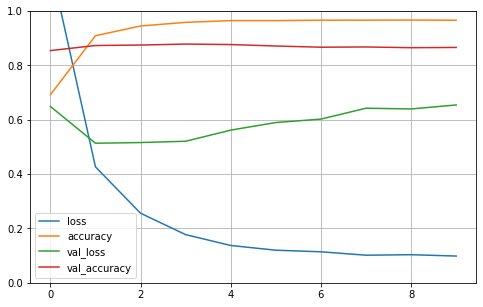

In [59]:
# Plot learning curves for model
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
# plt.savefig("figures/learning_curves_model_1", tight_layout=False)
plt.show()

## 1.2. DNN w/256 and 256 nodes

In [60]:
# This is the model we will use with data from the top 9 topics.
model_1a = Sequential()
model_1a.add(Dense(units =  256, activation='relu', input_shape=(voc_size,))) # vocabulary size = 10,000
model_1a.add(Dense(units =  256, activation='relu'))
model_1a.add(Dense(units =  9, activation='softmax'))

In [61]:
model_1a.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 256)               2560256   
_________________________________________________________________
dense_7 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_8 (Dense)              (None, 9)                 2313      
Total params: 2,628,361
Trainable params: 2,628,361
Non-trainable params: 0
_________________________________________________________________


In [62]:
model_1a.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [63]:
train_rt = TrainRuntimeCallback()
history = model_1a.fit(train_data_smv,
                    one_hot_train_labels_sm,
                    callbacks = [train_rt],
                    epochs=10,
                    batch_size=100,
#                     validation_data=(val_data_smv, one_hot_val_labels_sm))
                    validation_split = 0.15)   # comment out if setting validation_data value.

# Saving models locally after fitting
# save_dir = "results/"
# model_name = 'Reuters_1a.h5'
# model_path = os.path.join(save_dir, model_name)
# model_1a.save(model_path)
# print('Saved trained model at %s ' % model_path)
# print('--------------------------')

Epoch 1/10
64/64 [==============================] - 2s 36ms/step - loss: 0.8214 - accuracy: 0.7831 - val_loss: 0.5346 - val_accuracy: 0.8677
Epoch 2/10
64/64 [==============================] - 2s 34ms/step - loss: 0.2656 - accuracy: 0.9384 - val_loss: 0.5410 - val_accuracy: 0.8748
Epoch 3/10
64/64 [==============================] - 2s 34ms/step - loss: 0.1492 - accuracy: 0.9605 - val_loss: 0.5964 - val_accuracy: 0.8686
Epoch 4/10
64/64 [==============================] - 2s 34ms/step - loss: 0.1161 - accuracy: 0.9655 - val_loss: 0.5732 - val_accuracy: 0.8632
Epoch 5/10
64/64 [==============================] - 2s 34ms/step - loss: 0.1022 - accuracy: 0.9647 - val_loss: 0.6150 - val_accuracy: 0.8615
Epoch 6/10
64/64 [==============================] - 2s 34ms/step - loss: 0.0932 - accuracy: 0.9653 - val_loss: 0.6513 - val_accuracy: 0.8606
Epoch 7/10
64/64 [==============================] - 2s 34ms/step - loss: 0.0820 - accuracy: 0.9675 - val_loss: 0.6580 - val_accuracy: 0.8623
Epoch 8/10
64

In [64]:
# Get the training time
train_time = train_rt.process_time
train_time # in seconds

22.454012

In [65]:
print(f"train_acc: {history.history['accuracy'][-1]}, val_acc: {history.history['val_accuracy'][-1]}")

train_acc: 0.967069149017334, val_acc: 0.8614564538002014


### 1.2.a Model Testing

In [66]:
test_rt = TestRuntimeCallback()
test_loss, test_accuracy = model_1a.evaluate(test_data_smv, one_hot_test_labels_sm, callbacks=[test_rt], verbose=0)
print(f"test_accuracy={test_accuracy}, test_loss={test_loss}")

test_accuracy=0.8552916049957275, test_loss=0.749544620513916


In [67]:
# Get the test time
test_time = test_rt.process_time
test_time # in seconds

0.346137

### 1.2.b Model Performance

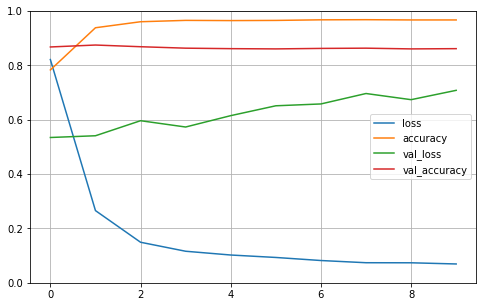

In [68]:
# Plot learning curves for model
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
# plt.savefig("figures/learning_curves_model_1a", tight_layout=False)
plt.show()

In [69]:
# Use history to collect statistics
history_dict = history.history
# history_dict['train_accuracy'] = history_dict.pop('accuracy') # rename the the key to 'test_accuracy'
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [70]:
# # DataFrame for model with 9 topics
history_df=pd.DataFrame(history_dict)
# history_df['test_accuracy'] = test_accuracy
# history_df = history_df.iloc[-1:]
history_df

,loss,accuracy,val_loss,val_accuracy
0,0.821387,0.783127,0.534597,0.867673
1,0.265649,0.938372,0.541009,0.874778
2,0.149197,0.960483,0.596352,0.868561
3,0.116093,0.965501,0.573161,0.863233
4,0.102227,0.964717,0.614989,0.861456
5,0.093239,0.965344,0.651256,0.860568
6,0.081966,0.967540,0.658026,0.862345
7,0.073861,0.968010,0.696405,0.863233
8,0.073619,0.967069,0.673748,0.860568
9,0.069291,0.967069,0.708131,0.861456


In [71]:
# Create a results DataFrame using the last row of history_df
results_df1a = history_df.iloc[-1:].copy()
results_df1a.insert(0,'model','DNN (2 layers 256/256)') # went the model name to appear first
results_df1a['test_accuracy'] = test_accuracy
results_df1a['test_loss'] = test_loss
results_df1a['training time (sec)'] = train_time      # we are okay with training time appearing last
results_df1a['testing time (sec)'] = test_time      # we are okay with training time appearing last
results_df1a

,model,loss,accuracy,val_loss,val_accuracy,test_accuracy,test_loss,training time (sec),testing time (sec)
9,DNN (2 layers 256/256),0.069291,0.967069,0.708131,0.861456,0.855292,0.749545,22.454012,0.346137


## 1.3 Baseline Model

In [72]:
test_labels_sm_copy = copy.copy(test_labels_sm)
np.random.shuffle(test_labels_sm_copy)
float(np.sum(np.array(test_labels_sm) == np.array(test_labels_sm_copy))) / len(test_labels_sm)
# test_labels_copy = copy.copy(test_labels)
# np.random.shuffle(test_labels_copy)
# float(np.sum(np.array(test_labels) == np.array(test_labels_copy))) / len(test_labels)

0.2818574514038877

## 1.3 Baseline Model w/10% dropout

In [73]:
model_1do = Sequential()
model_1do.add(Dense(units =64, activation='relu', input_shape=(voc_size,))) # vocabulary size = 10,000
model_1do.add(layers.Dropout(0.1))
model_1do.add(Dense(units =32, activation='relu'))
model_1do.add(layers.Dropout(0.1))
model_1do.add(Dense(units =9, activation='softmax'))

model_1do.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 64)                640064    
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 9)                 297       
Total params: 642,441
Trainable params: 642,441
Non-trainable params: 0
_________________________________________________________________


### 1.3.a Model Training

In [74]:
model_1do.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [75]:
train_rt = TrainRuntimeCallback()
history = model_1do.fit(train_data_smv,
                    one_hot_train_labels_sm,
                    callbacks = [train_rt],
                    epochs=10,
                    batch_size=100,
                    validation_split = 0.15)  

# Saving models locally after fitting
# save_dir = "results/"
# model_name = 'Reuters_1do.h5'
# model_path = os.path.join(save_dir, model_name)
# model_1do.save(model_path)
# print('Saved trained model at %s ' % model_path)
# print('--------------------------')

Epoch 1/10
64/64 [==============================] - 1s 15ms/step - loss: 1.1325 - accuracy: 0.6854 - val_loss: 0.6402 - val_accuracy: 0.8455
Epoch 2/10
64/64 [==============================] - 1s 12ms/step - loss: 0.4990 - accuracy: 0.8796 - val_loss: 0.5290 - val_accuracy: 0.8721
Epoch 3/10
64/64 [==============================] - 1s 13ms/step - loss: 0.3156 - accuracy: 0.9288 - val_loss: 0.5223 - val_accuracy: 0.8757
Epoch 4/10
64/64 [==============================] - 1s 12ms/step - loss: 0.2219 - accuracy: 0.9479 - val_loss: 0.5305 - val_accuracy: 0.8766
Epoch 5/10
64/64 [==============================] - 1s 13ms/step - loss: 0.1692 - accuracy: 0.9584 - val_loss: 0.5610 - val_accuracy: 0.8748
Epoch 6/10
64/64 [==============================] - 1s 13ms/step - loss: 0.1452 - accuracy: 0.9617 - val_loss: 0.5923 - val_accuracy: 0.8712
Epoch 7/10
64/64 [==============================] - 1s 12ms/step - loss: 0.1243 - accuracy: 0.9653 - val_loss: 0.6159 - val_accuracy: 0.8677
Epoch 8/10
64

In [76]:
# Get the training time
train_time = train_rt.process_time
train_time # in seconds

8.779403

### 1.3.b Model Testing

In [77]:
test_rt = TestRuntimeCallback()
test_loss, test_accuracy = model_1do.evaluate(test_data_smv, one_hot_test_labels_sm, callbacks=[test_rt], verbose=0) 
print(f"test_accuracy={test_accuracy}, test_loss={test_loss}")

test_accuracy=0.8536717295646667, test_loss=0.6934414505958557


In [78]:
# Get the test time
test_time = test_rt.process_time
test_time # in seconds

0.148081

### 1.3.c Model Performance

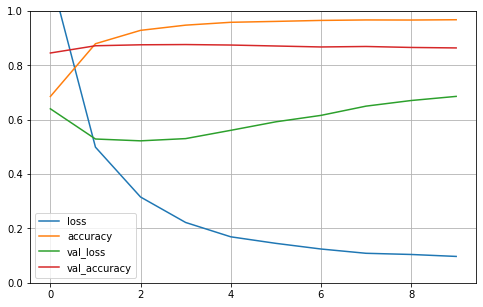

In [79]:
# Plot learning curves for model
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
# plt.savefig("figures/learning_curves_model_1do", tight_layout=False)
plt.show()

In [80]:
history_dict = history.history
# history_dict['train_accuracy'] = history_dict.pop('accuracy') # rename the the key to 'test_accuracy'
history_df=pd.DataFrame(history_dict)

In [81]:
results_df1do = history_df.iloc[-1:].copy()
results_df1do.insert(0,'model','DNN (2 layers) w Drop') # want the model name to appear first
results_df1do['test_accuracy'] = test_accuracy
results_df1do['test_loss'] = test_loss
results_df1do['training time (sec)'] = train_time      # we are okay with training time appearing last
results_df1do['testing time (sec)'] = test_time      # we are okay with training time appearing last
results_df1do

,model,loss,accuracy,val_loss,val_accuracy,test_accuracy,test_loss,training time (sec),testing time (sec)
9,DNN (2 layers) w Drop,0.097031,0.967853,0.685843,0.864121,0.853672,0.693441,8.779403,0.148081


## 1.4: Baseline Model w/10% dropout and L1 regularization

In [82]:
model_1reg = Sequential()
model_1reg.add(Dense(units=64, kernel_regularizer=regularizers.l1(0.001), activation='relu', input_shape=(voc_size,))) # vocabulary size = 10,000
model_1reg.add(layers.Dropout(0.1))
model_1reg.add(Dense(units=32, kernel_regularizer=regularizers.l1(0.001), activation='relu'))
model_1reg.add(layers.Dropout(0.1))
model_1reg.add(Dense(units=9, activation='softmax'))

model_1reg.summary()


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 64)                640064    
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 9)                 297       
Total params: 642,441
Trainable params: 642,441
Non-trainable params: 0
_________________________________________________________________


### 1.4.a Model Training

In [83]:
model_1reg.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [84]:
train_rt = TrainRuntimeCallback()
history = model_1reg.fit(train_data_smv,
                    one_hot_train_labels_sm,
                    callbacks = [train_rt],
                    epochs=10,
                    batch_size=100,
                    validation_split = 0.15) 

# Saving models locally after fitting
# save_dir = "results/"
# model_name = 'Reuters_1reg.h5'
# model_path = os.path.join(save_dir, model_name)
# model_1reg.save(model_path)
# print('Saved trained model at %s ' % model_path)
# print('--------------------------')

Epoch 1/10
64/64 [==============================] - 1s 18ms/step - loss: 3.2474 - accuracy: 0.6412 - val_loss: 1.4984 - val_accuracy: 0.8002
Epoch 2/10
64/64 [==============================] - 1s 16ms/step - loss: 1.3662 - accuracy: 0.8114 - val_loss: 1.2545 - val_accuracy: 0.8330
Epoch 3/10
64/64 [==============================] - 1s 16ms/step - loss: 1.2111 - accuracy: 0.8404 - val_loss: 1.1789 - val_accuracy: 0.8419
Epoch 4/10
64/64 [==============================] - 1s 16ms/step - loss: 1.1512 - accuracy: 0.8495 - val_loss: 1.1323 - val_accuracy: 0.8535
Epoch 5/10
64/64 [==============================] - 1s 17ms/step - loss: 1.1068 - accuracy: 0.8600 - val_loss: 1.1037 - val_accuracy: 0.8615
Epoch 6/10
64/64 [==============================] - 1s 16ms/step - loss: 1.0901 - accuracy: 0.8615 - val_loss: 1.1125 - val_accuracy: 0.8544
Epoch 7/10
64/64 [==============================] - 1s 16ms/step - loss: 1.0783 - accuracy: 0.8722 - val_loss: 1.0809 - val_accuracy: 0.8650
Epoch 8/10
64

In [85]:
# Get the training time
train_time = train_rt.process_time
train_time # in seconds

11.099286

### 1.4.b Model Testing

In [86]:
test_rt = TestRuntimeCallback()
test_loss, test_accuracy = model_1reg.evaluate(test_data_smv, one_hot_test_labels_sm, callbacks=[test_rt], verbose=0) 
print(f"test_accuracy={test_accuracy}, test_loss={test_loss}")

test_accuracy=0.8628509640693665, test_loss=1.097510814666748


In [87]:
# Get the test time
test_time = test_rt.process_time
test_time # in seconds

0.205867

### 1.4.c Model Performance

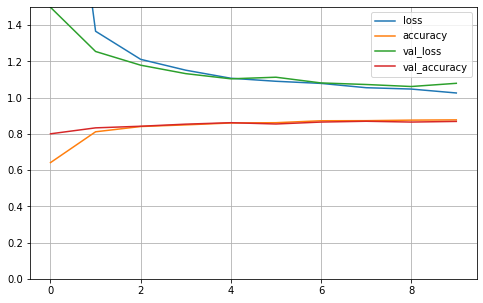

In [88]:
# Plot learning curves for model
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1.5) # set the vertical range to [0-1]
# plt.savefig("figures/learning_curves_model_1reg", tight_layout=False)
plt.show()

In [89]:
history_dict = history.history
# history_dict['train_accuracy'] = history_dict.pop('accuracy') # rename the the key to 'test_accuracy'
history_df=pd.DataFrame(history_dict)

In [90]:
results_df1reg = history_df.iloc[-1:].copy()
results_df1reg.insert(0,'model','DNN (2 layers) w Drop and L1') # want the model name to appear first
results_df1reg['test_accuracy'] = test_accuracy
results_df1reg['test_loss'] = test_loss
results_df1reg['training time (sec)'] = train_time      # we are okay with training time appearing last
results_df1reg['testing time (sec)'] = test_time      # we are okay with training time appearing last
results_df1reg

,model,loss,accuracy,val_loss,val_accuracy,test_accuracy,test_loss,training time (sec),testing time (sec)
9,DNN (2 layers) w Drop and L1,1.025516,0.877058,1.078874,0.868561,0.862851,1.097511,11.099286,0.205867


## 1.5 Baseline Model w/embedding layer

In [91]:
train_data_smv.shape

(7503, 10000)

In [92]:
train_data_sm_len =[len(w) for w in train_data_sm]
maxlen = int(np.percentile(train_data_sm_len, 80))
f"80th percentile of train_data_sm : {maxlen}"

'80th percentile of train_data_sm : 193'

In [93]:
# https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/6.1-using-word-embeddings.ipynb
train_data_smv = preprocessing.sequence.pad_sequences(train_data_sm, maxlen=maxlen)
test_data_smv = preprocessing.sequence.pad_sequences(test_data_sm, maxlen=maxlen)

In [94]:
# https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/6.1-using-word-embeddings.ipynb
model_1emb = Sequential()

# We specify the maximum input length to our Embedding layer so we can later flatten the embedded inputs
model_1emb.add(Embedding(voc_size, 128, input_length = maxlen))  # vocabulary size = 10,000
# After the Embedding layer, our activations have shape `(samples, maxlen, 30)`.

# We flatten the 3D tensor of embeddings into a 2D tensor of shape `(samples, maxlen * 30)`
model_1emb.add(Flatten())
model_1emb.add(Dense(units = 64, activation='relu'))
model_1emb.add(Dense(units = 32, activation='relu'))

# We add the classifier on top
model_1emb.add(Dense(units = 9, activation='softmax'))
model_1emb.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 193, 128)          1280000   
_________________________________________________________________
flatten (Flatten)            (None, 24704)             0         
_________________________________________________________________
dense_15 (Dense)             (None, 64)                1581120   
_________________________________________________________________
dense_16 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_17 (Dense)             (None, 9)                 297       
Total params: 2,863,497
Trainable params: 2,863,497
Non-trainable params: 0
_________________________________________________________________


### 1.5.a Model Training

In [95]:
model_1emb.compile(optimizer='adam', 
                   loss='categorical_crossentropy', 
                   metrics=['accuracy'])

In [96]:
train_rt = TrainRuntimeCallback()
history = model_1emb.fit(train_data_smv,             
                    one_hot_train_labels_sm,  
                    callbacks = [train_rt],
                    epochs=10,
                    batch_size=100,
                    validation_split = 0.15)

# Saving models locally after fitting
# save_dir = "results/"
# model_name = 'Reuters_1emb.h5'
# model_path = os.path.join(save_dir, model_name)
# model_1emb.save(model_path)
# print('Saved trained model at %s ' % model_path)
# print('--------------------------')

Epoch 1/10
64/64 [==============================] - 4s 58ms/step - loss: 1.2885 - accuracy: 0.5681 - val_loss: 0.9479 - val_accuracy: 0.7123
Epoch 2/10
64/64 [==============================] - 3s 55ms/step - loss: 0.6271 - accuracy: 0.8181 - val_loss: 0.7593 - val_accuracy: 0.7735
Epoch 3/10
64/64 [==============================] - 4s 56ms/step - loss: 0.2644 - accuracy: 0.9388 - val_loss: 0.7516 - val_accuracy: 0.7993
Epoch 4/10
64/64 [==============================] - 4s 58ms/step - loss: 0.1441 - accuracy: 0.9641 - val_loss: 0.7465 - val_accuracy: 0.8117
Epoch 5/10
64/64 [==============================] - 3s 54ms/step - loss: 0.1143 - accuracy: 0.9666 - val_loss: 0.7525 - val_accuracy: 0.8055
Epoch 6/10
64/64 [==============================] - 3s 55ms/step - loss: 0.0993 - accuracy: 0.9675 - val_loss: 0.8084 - val_accuracy: 0.7984
Epoch 7/10
64/64 [==============================] - 4s 56ms/step - loss: 0.0901 - accuracy: 0.9685 - val_loss: 0.8019 - val_accuracy: 0.8082
Epoch 8/10
64

In [97]:
# Get the training time
train_time = train_rt.process_time
train_time # in seconds

36.517626

### 1.5.b Model Testing

In [98]:
test_rt = TestRuntimeCallback()
test_loss, test_accuracy = model_1emb.evaluate(test_data_smv, one_hot_test_labels_sm, callbacks=[test_rt], verbose=0)
print(f"test_accuracy={test_accuracy}, test_loss={test_loss}")

test_accuracy=0.78995680809021, test_loss=0.8822323083877563


In [99]:
# Get the test time
test_time = test_rt.process_time
test_time # in seconds

0.25309

### 1.5.c Model Performance

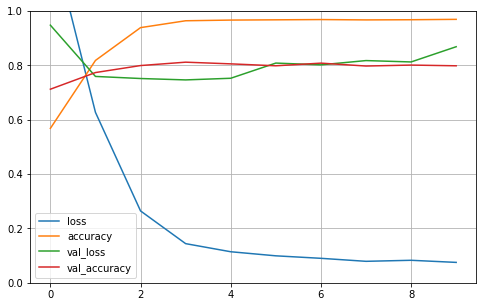

In [100]:
# Plot learning curves for model
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
# plt.savefig("figures/learning_curves_model_1b", tight_layout=False)
plt.show()

In [101]:
history_dict = history.history.copy()
# history_dict['train_accuracy'] = history_dict.pop('accuracy') # rename the the key to 'test_accuracy'
history_df=pd.DataFrame(history_dict)

In [102]:
results_dfemb = history_df.iloc[-1:].copy()
results_dfemb.insert(0,'model','DNN (2 layers) w Embed') # want the model name to appear first
results_dfemb['test_accuracy'] = test_accuracy
results_dfemb['test_loss'] = test_loss
results_dfemb['training time (sec)'] = train_time
results_dfemb['testing time (sec)'] = test_time     
results_dfemb


,model,loss,accuracy,val_loss,val_accuracy,test_accuracy,test_loss,training time (sec),testing time (sec)
9,DNN (2 layers) w Embed,0.075075,0.969265,0.868562,0.798401,0.789957,0.882232,36.517626,0.25309


### 1.6: Baseline Model w/embedding and 10% dropout

In [103]:
# https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/6.1-using-word-embeddings.ipynb
# from tensorflow.keras.layers import Flatten, Embedding

model_1embdo = Sequential()
model_1embdo.add(Embedding(voc_size, 128, input_length = maxlen))  # vocabulary size = 10,000
model_1embdo.add(Flatten())

model_1embdo.add(Dense(units=64, activation='relu'))
model_1embdo.add(layers.Dropout(0.1))
model_1embdo.add(Dense(units=32, activation='relu'))
model_1embdo.add(layers.Dropout(0.1))
model_1embdo.add(Dense(units=9, activation='softmax'))
model_1embdo.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 193, 128)          1280000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 24704)             0         
_________________________________________________________________
dense_18 (Dense)             (None, 64)                1581120   
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_5 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 9)                

### 1.7.a Model Training

In [104]:
model_1embdo.compile(optimizer='adam', 
                     loss='categorical_crossentropy', 
                     metrics=['accuracy'])

In [105]:
train_rt = TrainRuntimeCallback()
history = model_1embdo.fit(train_data_smv,             
                    one_hot_train_labels_sm,  
                    callbacks = [train_rt],
                    epochs=10,
                    batch_size=100,
                    validation_split = 0.15)

# Saving models locally after fitting
# save_dir = "results/"
# model_name = 'Reuters_1embdo.h5'
# model_path = os.path.join(save_dir, model_name)
# model_1embdo.save(model_path)
# print('Saved trained model at %s ' % model_path)
# print('--------------------------')

Epoch 1/10
64/64 [==============================] - 3s 55ms/step - loss: 1.3345 - accuracy: 0.5630 - val_loss: 0.9598 - val_accuracy: 0.6767
Epoch 2/10
64/64 [==============================] - 3s 54ms/step - loss: 0.7338 - accuracy: 0.7822 - val_loss: 0.7576 - val_accuracy: 0.7709
Epoch 3/10
64/64 [==============================] - 3s 53ms/step - loss: 0.3531 - accuracy: 0.9122 - val_loss: 0.7039 - val_accuracy: 0.8153
Epoch 4/10
64/64 [==============================] - 3s 53ms/step - loss: 0.1954 - accuracy: 0.9591 - val_loss: 0.6912 - val_accuracy: 0.8188
Epoch 5/10
64/64 [==============================] - 3s 54ms/step - loss: 0.1407 - accuracy: 0.9636 - val_loss: 0.7236 - val_accuracy: 0.8224
Epoch 6/10
64/64 [==============================] - 3s 53ms/step - loss: 0.1147 - accuracy: 0.9680 - val_loss: 0.7849 - val_accuracy: 0.8162
Epoch 7/10
64/64 [==============================] - 4s 56ms/step - loss: 0.1026 - accuracy: 0.9680 - val_loss: 0.7699 - val_accuracy: 0.8179
Epoch 8/10
64

In [106]:
# Get the training time
train_time = train_rt.process_time
train_time # in seconds

35.832285

### 1.7.b Model Testing

In [107]:
test_rt = TestRuntimeCallback()
test_loss, test_accuracy = model_1embdo.evaluate(test_data_smv, one_hot_test_labels_sm, callbacks=[test_rt], verbose=0)
print(f"test_accuracy={test_accuracy}, test_loss={test_loss}")

test_accuracy=0.8077753782272339, test_loss=0.8941773176193237


In [108]:
# Get the test time
test_time = test_rt.process_time
test_time # in seconds

0.248716

### 1.7.c Model Performance

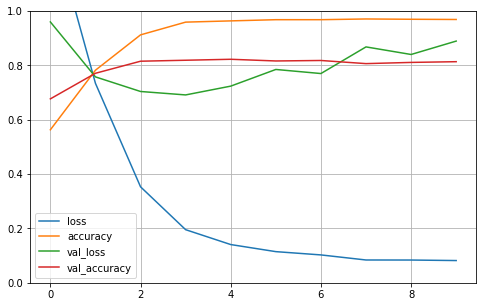

In [109]:
# Plot learning curves for model
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
# plt.savefig("figures/learning_curves_model_1_c", tight_layout=False)
plt.show()

In [110]:
history_dict = history.history.copy()
# history_dict['train_accuracy'] = history_dict.pop('accuracy') # rename the the key to 'test_accuracy'
history_df=pd.DataFrame(history_dict)

In [111]:
results_dfembdo = history_df.iloc[-1:].copy()
results_dfembdo.insert(0,'model','DNN (2 layers) w Embed + Dropout') # want the model name to appear first
results_dfembdo['test_accuracy'] = test_accuracy
results_dfembdo['test_loss'] = test_loss
results_dfembdo['training time (sec)'] = train_time      
results_dfembdo['testing time (sec)'] = test_time     
results_dfembdo

,model,loss,accuracy,val_loss,val_accuracy,test_accuracy,test_loss,training time (sec),testing time (sec)
9,DNN (2 layers) w Embed + Dropout,0.081857,0.968794,0.889317,0.813499,0.807775,0.894177,35.832285,0.248716


In [112]:
results_df=results_df.append(results_df1a,ignore_index=True)
results_df=results_df.append(results_df1do,ignore_index=True)
results_df=results_df.append(results_df1reg,ignore_index=True)
results_df=results_df.append(results_dfemb,ignore_index=True)
results_df=results_df.append(results_dfembdo,ignore_index=True)
results_df

,model,loss,accuracy,val_loss,val_accuracy,test_accuracy,test_loss,training time (sec),testing time (sec)
0,DNN (2 layers) 9 topics,0.098419,0.965971,0.654334,0.865897,0.857991,0.680301,8.366051,0.130511
1,DNN (2 layers 256/256),0.069291,0.967069,0.708131,0.861456,0.855292,0.749545,22.454012,0.346137
2,DNN (2 layers) w Drop,0.097031,0.967853,0.685843,0.864121,0.853672,0.693441,8.779403,0.148081
3,DNN (2 layers) w Drop and L1,1.025516,0.877058,1.078874,0.868561,0.862851,1.097511,11.099286,0.205867
4,DNN (2 layers) w Embed,0.075075,0.969265,0.868562,0.798401,0.789957,0.882232,36.517626,0.253090
5,DNN (2 layers) w Embed + Dropout,0.081857,0.968794,0.889317,0.813499,0.807775,0.894177,35.832285,0.248716


In [115]:
results_df.to_pickle("results1.pkl") 

## 2. Experiment 2: RNN

In [190]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [191]:
train_data_sm.shape, test_data_sm.shape

((7503,), (1852,))

In [192]:
train_data_sm_rnn = preprocessing.sequence.pad_sequences(train_data_sm, maxlen=193)
test_data_sm_rnn = preprocessing.sequence.pad_sequences(test_data_sm, maxlen=193)

In [193]:
one_hot_train_labels_sm = to_categorical(train_labels_sm)
one_hot_test_labels_sm = to_categorical(test_labels_sm)

In [194]:
train_labels_sm.shape, one_hot_train_labels_sm.shape

((7503,), (7503, 21))

In [195]:
test_data_sm_rnn.shape, train_data_sm_rnn.shape, one_hot_train_labels_sm.shape, one_hot_test_labels_sm.shape

((1852, 193), (7503, 193), (7503, 21), (1852, 21))

## 2.1 RNN w/64 cells

In [196]:
model_2 = Sequential()
model_2.add(Embedding(input_dim = voc_size, output_dim = 128, input_length = 193))
model_2.add(SimpleRNN(units = 64))
model_2.add(Dense(units = 21, activation='softmax'))

model_2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 193, 128)          1280000   
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 64)                12352     
_________________________________________________________________
dense (Dense)                (None, 21)                1365      
Total params: 1,293,717
Trainable params: 1,293,717
Non-trainable params: 0
_________________________________________________________________


In [197]:
model_2.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### 2.1.a Model Training

In [198]:
train_rt = TrainRuntimeCallback()
history = model_2.fit(train_data_sm_rnn,
                    one_hot_train_labels_sm,
                    callbacks = [train_rt],
                    epochs=10,
                    batch_size=100,
#                   validation_data=(val_data_sm_rnn, one_hot_val_labels_sm))
                    validation_split = 0.15)   # comment out if setting validation_data value.

# Saving models locally after fitting
# save_dir = "results/"
# model_name = 'Reuters_2.h5'
# model_path = os.path.join(save_dir, model_name)
# model_2.save(model_path)
# print('Saved trained model at %s ' % model_path)
# print('--------------------------')

Epoch 1/10
64/64 [==============================] - 7s 111ms/step - loss: 1.7567 - accuracy: 0.5404 - val_loss: 1.3439 - val_accuracy: 0.5799
Epoch 2/10
64/64 [==============================] - 7s 108ms/step - loss: 1.1566 - accuracy: 0.6215 - val_loss: 1.2028 - val_accuracy: 0.6181
Epoch 3/10
64/64 [==============================] - 7s 107ms/step - loss: 0.8250 - accuracy: 0.7433 - val_loss: 1.1342 - val_accuracy: 0.6545
Epoch 4/10
64/64 [==============================] - 7s 110ms/step - loss: 0.4834 - accuracy: 0.8946 - val_loss: 1.1829 - val_accuracy: 0.6332
Epoch 5/10
64/64 [==============================] - 7s 109ms/step - loss: 0.2745 - accuracy: 0.9487 - val_loss: 1.2256 - val_accuracy: 0.6421
Epoch 6/10
64/64 [==============================] - 7s 109ms/step - loss: 0.1808 - accuracy: 0.9619 - val_loss: 1.2647 - val_accuracy: 0.6456
Epoch 7/10
64/64 [==============================] - 7s 108ms/step - loss: 0.1333 - accuracy: 0.9671 - val_loss: 1.3725 - val_accuracy: 0.6306
Epoch 

In [199]:
# Get the training time
train_time = train_rt.process_time
train_time # in seconds

71.55403

In [200]:
print(f"train_acc: {history.history['accuracy'][-1]}, val_acc: {history.history['val_accuracy'][-1]}")

train_acc: 0.9680100083351135, val_acc: 0.6110124588012695


### 2.1.b Model Testing

In [201]:
test_rt = TestRuntimeCallback()
test_loss, test_accuracy = model_2.evaluate(test_data_sm_rnn, one_hot_test_labels_sm, callbacks=[test_rt], verbose=0)
print(f"test_accuracy={test_accuracy}, test_loss={test_loss}")

test_accuracy=0.624190092086792, test_loss=1.4295098781585693


In [202]:
# Get the test time
test_time = test_rt.process_time
test_time # in seconds

0.751699

### 2.1.c Model Performance

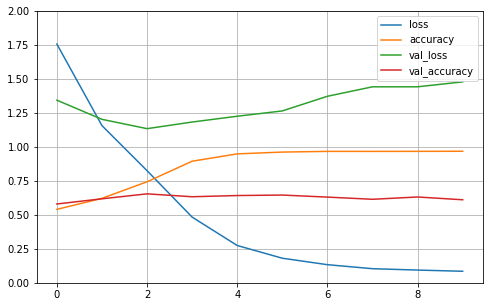

In [203]:
# Plot learning curves for model
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 2) # set the vertical range to [0-1.5]
# plt.savefig("figures/learning_curves_model_2", tight_layout=False)
plt.show()

In [204]:
history_dict = history.history.copy()
# history_dict['train_accuracy'] = history_dict.pop('accuracy') # rename the the key to 'test_accuracy'
history_df=pd.DataFrame(history_dict)

In [205]:
results_df2 = history_df.iloc[-1:].copy()
results_df2.insert(0,'model','Simple RNN (64 units)') # want the model name to appear first
results_df2['test_accuracy'] = test_accuracy
results_df2['test_loss'] = test_loss
results_df2['training time (sec)'] = train_time      
results_df2['testing time (sec)'] = test_time      
results_df2

,model,loss,accuracy,val_loss,val_accuracy,test_accuracy,test_loss,training time (sec),testing time (sec)
9,Simple RNN (64 units),0.084814,0.96801,1.478557,0.611012,0.62419,1.42951,71.55403,0.751699


## 2.2 RNN w/100 memory cells

In [206]:
model_2a = Sequential()
model_2a.add(Embedding(input_dim = voc_size, output_dim = 128, input_length = 193))
model_2a.add(SimpleRNN(units = 100))
model_2a.add(Dense(units = 21, activation='softmax'))

model_2a.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 193, 128)          1280000   
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 100)               22900     
_________________________________________________________________
dense_1 (Dense)              (None, 21)                2121      
Total params: 1,305,021
Trainable params: 1,305,021
Non-trainable params: 0
_________________________________________________________________


In [207]:
model_2a.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### 2.2.a Model Training

In [208]:
train_rt = TrainRuntimeCallback()
history = model_2a.fit(train_data_sm_rnn,
                    one_hot_train_labels_sm,
                    callbacks = [train_rt],
                    epochs=10,
                    batch_size=100,
#                   validation_data=(val_data_sm_rnn, one_hot_val_labels_sm))
                    validation_split = 0.15)   # comment out if setting validation_data value.

# Saving models locally after fitting
# save_dir = "results/"
# model_name = 'Reuters_2a.h5'
# model_path = os.path.join(save_dir, model_name)
# model_2a.save(model_path)
# print('Saved trained model at %s ' % model_path)
# print('--------------------------')

Epoch 1/10
64/64 [==============================] - 9s 148ms/step - loss: 1.8224 - accuracy: 0.4185 - val_loss: 1.6398 - val_accuracy: 0.4112
Epoch 2/10
64/64 [==============================] - 9s 144ms/step - loss: 1.4616 - accuracy: 0.5208 - val_loss: 1.4498 - val_accuracy: 0.5160
Epoch 3/10
64/64 [==============================] - 9s 145ms/step - loss: 1.0983 - accuracy: 0.6500 - val_loss: 1.5144 - val_accuracy: 0.5124
Epoch 4/10
64/64 [==============================] - 9s 145ms/step - loss: 0.7228 - accuracy: 0.7944 - val_loss: 1.5352 - val_accuracy: 0.5222
Epoch 5/10
64/64 [==============================] - 9s 145ms/step - loss: 0.4244 - accuracy: 0.8948 - val_loss: 1.6274 - val_accuracy: 0.5329
Epoch 6/10
64/64 [==============================] - 9s 148ms/step - loss: 0.2532 - accuracy: 0.9421 - val_loss: 1.6350 - val_accuracy: 0.5266
Epoch 7/10
64/64 [==============================] - 9s 145ms/step - loss: 0.1630 - accuracy: 0.9605 - val_loss: 1.6425 - val_accuracy: 0.5595
Epoch 

In [209]:
# Get the training time
train_time = train_rt.process_time
train_time # in seconds

95.429328

In [210]:
print(f"train_acc: {history.history['accuracy'][-1]}, val_acc: {history.history['val_accuracy'][-1]}")

train_acc: 0.9661282896995544, val_acc: 0.5310834646224976


### 2.2.b Model Testing

In [211]:
test_rt = TestRuntimeCallback()
test_loss, test_accuracy = model_2a.evaluate(test_data_sm_rnn, one_hot_test_labels_sm, callbacks=[test_rt], verbose=0)
print(f"test_accuracy={test_accuracy}, test_loss={test_loss}")

test_accuracy=0.5485960841178894, test_loss=1.8140709400177002


In [212]:
# Get the test time
test_time = test_rt.process_time
test_time # in seconds

0.966891

### 2.2.c Model Performance

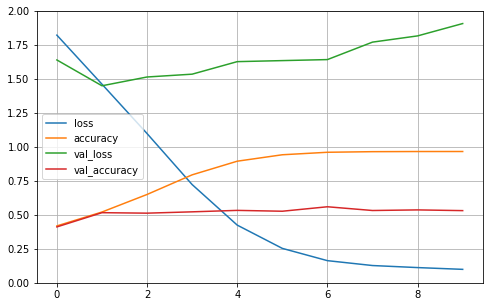

In [213]:
# Plot learning curves for model
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 2) # set the vertical range to [0-1]
# plt.savefig("figures/learning_curves_model_2a", tight_layout=False)
plt.show()

In [214]:
history_dict = history.history.copy()
# history_dict['train_accuracy'] = history_dict.pop('accuracy') # rename the the key to 'test_accuracy'
history_df=pd.DataFrame(history_dict)

In [215]:
results_df2a = history_df.iloc[-1:].copy()
results_df2a.insert(0,'model','Simple RNN (100 units)') # want the model name to appear first
results_df2a['test_accuracy'] = test_accuracy
results_df2a['test_loss'] = test_loss
results_df2a['training time (sec)'] = train_time      
results_df2a['testing time (sec)'] = test_time     
results_df2a

,model,loss,accuracy,val_loss,val_accuracy,test_accuracy,test_loss,training time (sec),testing time (sec)
9,Simple RNN (100 units),0.098973,0.966128,1.907632,0.531083,0.548596,1.814071,95.429328,0.966891


In [216]:
results_df2=results_df2.append(results_df2a,ignore_index=True)
results_df2

,model,loss,accuracy,val_loss,val_accuracy,test_accuracy,test_loss,training time (sec),testing time (sec)
0,Simple RNN (64 units),0.084814,0.968010,1.478557,0.611012,0.624190,1.429510,71.554030,0.751699
1,Simple RNN (100 units),0.098973,0.966128,1.907632,0.531083,0.548596,1.814071,95.429328,0.966891


In [217]:
results_df2.to_pickle("results2.pkl") 

## 2.3 RNN w/32 cells and dropout

In [222]:
model_2c = Sequential()
model_2c.add(Embedding(input_dim = voc_size, output_dim = 128, input_length = 193))
model_2c.add(SimpleRNN(units = 32))
model_2c.add(layers.Dropout(0.2))
model_2c.add(Dense(units = 21, activation='softmax'))

model_2c.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 193, 128)          1280000   
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, 32)                5152      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 21)                693       
Total params: 1,285,845
Trainable params: 1,285,845
Non-trainable params: 0
_________________________________________________________________


In [223]:
model_2c.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### 2.3.a Model Training

In [224]:
train_rt = TrainRuntimeCallback()
history = model_2c.fit(train_data_sm_rnn,
                    one_hot_train_labels_sm,
                    callbacks = [train_rt],
                    epochs=10,
                    batch_size=100,
#                   validation_data=(val_data_sm_rnn, one_hot_val_labels_sm))
                    validation_split = 0.15)   # comment out if setting validation_data value.

# Saving models locally after fitting
# save_dir = "results/"
# model_name = 'Reuters_2a.h5'
# model_path = os.path.join(save_dir, model_name)
# model_2a.save(model_path)
# print('Saved trained model at %s ' % model_path)
# print('--------------------------')

Epoch 1/10
64/64 [==============================] - 6s 90ms/step - loss: 2.1509 - accuracy: 0.3974 - val_loss: 1.7267 - val_accuracy: 0.5142
Epoch 2/10
64/64 [==============================] - 6s 88ms/step - loss: 1.5150 - accuracy: 0.5608 - val_loss: 1.4040 - val_accuracy: 0.5622
Epoch 3/10
64/64 [==============================] - 6s 90ms/step - loss: 1.1777 - accuracy: 0.6517 - val_loss: 1.2466 - val_accuracy: 0.5808
Epoch 4/10
64/64 [==============================] - 6s 87ms/step - loss: 0.9259 - accuracy: 0.7273 - val_loss: 1.0972 - val_accuracy: 0.6501
Epoch 5/10
64/64 [==============================] - 6s 87ms/step - loss: 0.7710 - accuracy: 0.7957 - val_loss: 1.1441 - val_accuracy: 0.6572
Epoch 6/10
64/64 [==============================] - 6s 87ms/step - loss: 0.6602 - accuracy: 0.8324 - val_loss: 1.2713 - val_accuracy: 0.6306
Epoch 7/10
64/64 [==============================] - 6s 90ms/step - loss: 0.5680 - accuracy: 0.8614 - val_loss: 1.1232 - val_accuracy: 0.6687
Epoch 8/10
64

In [225]:
# Get the training time
train_time = train_rt.process_time
train_time # in seconds

58.333397

In [226]:
print(f"train_acc: {history.history['accuracy'][-1]}, val_acc: {history.history['val_accuracy'][-1]}")

train_acc: 0.9026187658309937, val_acc: 0.6056838631629944


### 2.3.b Model Testing

In [227]:
test_rt = TestRuntimeCallback()
test_loss, test_accuracy = model_2c.evaluate(test_data_sm_rnn, one_hot_test_labels_sm, callbacks=[test_rt], verbose=0)
print(f"test_accuracy={test_accuracy}, test_loss={test_loss}")

test_accuracy=0.6166306734085083, test_loss=1.2623393535614014


In [228]:
# Get the test time
test_time = test_rt.process_time
test_time # in seconds

0.661645

### 2.3.c Model Performance

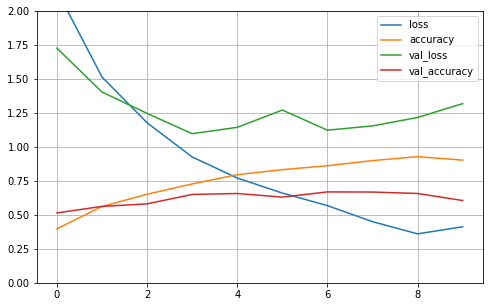

In [229]:
# Plot learning curves for model
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 2) # set the vertical range to [0-1]
# plt.savefig("figures/learning_curves_model_2a", tight_layout=False)
plt.show()

In [230]:
history_dict = history.history.copy()
# history_dict['train_accuracy'] = history_dict.pop('accuracy') # rename the the key to 'test_accuracy'
history_df=pd.DataFrame(history_dict)

In [231]:
results_df2c = history_df.iloc[-1:].copy()
results_df2c.insert(0,'model','Simple RNN (32 units w/dropout)') # want the model name to appear first
results_df2c['test_accuracy'] = test_accuracy
results_df2c['test_loss'] = test_loss
results_df2c['training time (sec)'] = train_time      
results_df2c['testing time (sec)'] = test_time     
results_df2c

,model,loss,accuracy,val_loss,val_accuracy,test_accuracy,test_loss,training time (sec),testing time (sec)
9,Simple RNN (32 units w/dropout),0.412491,0.902619,1.318407,0.605684,0.616631,1.262339,58.333397,0.661645


In [232]:
results_df2=results_df2.append(results_df2c,ignore_index=True)
results_df2

,model,loss,accuracy,val_loss,val_accuracy,test_accuracy,test_loss,training time (sec),testing time (sec)
0,Simple RNN (64 units),0.084814,0.968010,1.478557,0.611012,0.624190,1.429510,71.554030,0.751699
1,Simple RNN (100 units),0.098973,0.966128,1.907632,0.531083,0.548596,1.814071,95.429328,0.966891
2,Simple RNN (32 units w/dropout),0.412491,0.902619,1.318407,0.605684,0.616631,1.262339,58.333397,0.661645


In [233]:
results_df2.to_pickle("results2.pkl") 

# 3. Experiment 3: LSTM RNN

In [234]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

## 3.1 LSTM RNN

In [235]:
model_3 = Sequential()
model_3.add(Embedding(input_dim = voc_size, output_dim = 64, input_length = 193))
model_3.add(LSTM(units = 32))
model_3.add(Dense(units = 21, activation='softmax'))

model_3.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 193, 64)           640000    
_________________________________________________________________
lstm (LSTM)                  (None, 32)                12416     
_________________________________________________________________
dense (Dense)                (None, 21)                693       
Total params: 653,109
Trainable params: 653,109
Non-trainable params: 0
_________________________________________________________________


In [236]:
model_3.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### 3.1.a Model Training

In [237]:
train_rt = TrainRuntimeCallback()
history = model_3.fit(train_data_sm_rnn,
                    one_hot_train_labels_sm,
                    callbacks = [train_rt],
                    epochs=10,
                    batch_size=100,
#                   validation_data=(val_data_sm_rnn, one_hot_val_labels_sm))
                    validation_split = 0.15)   # comment out if setting validation_data value.

# Saving models locally after fitting
# save_dir = "results/"
# model_name = 'Reuters_3.h5'
# model_path = os.path.join(save_dir, model_name)
# model_3.save(model_path)
# print('Saved trained model at %s ' % model_path)
# print('--------------------------')

Epoch 1/10
64/64 [==============================] - 9s 134ms/step - loss: 2.2227 - accuracy: 0.4319 - val_loss: 1.5064 - val_accuracy: 0.5737
Epoch 2/10
64/64 [==============================] - 8s 125ms/step - loss: 1.2819 - accuracy: 0.6033 - val_loss: 1.1294 - val_accuracy: 0.6652
Epoch 3/10
64/64 [==============================] - 8s 125ms/step - loss: 1.0517 - accuracy: 0.6718 - val_loss: 1.0763 - val_accuracy: 0.6803
Epoch 4/10
64/64 [==============================] - 8s 126ms/step - loss: 0.9718 - accuracy: 0.6867 - val_loss: 0.9906 - val_accuracy: 0.6767
Epoch 5/10
64/64 [==============================] - 8s 126ms/step - loss: 0.8978 - accuracy: 0.7082 - val_loss: 0.9664 - val_accuracy: 0.6901
Epoch 6/10
64/64 [==============================] - 8s 125ms/step - loss: 0.8122 - accuracy: 0.7467 - val_loss: 0.9091 - val_accuracy: 0.7265
Epoch 7/10
64/64 [==============================] - 8s 127ms/step - loss: 0.8953 - accuracy: 0.7245 - val_loss: 0.9498 - val_accuracy: 0.7220
Epoch 

In [238]:
# Get the training time
train_time = train_rt.process_time
train_time # in seconds

83.972107

In [239]:
print(f"train_acc: {history.history['accuracy'][-1]}, val_acc: {history.history['val_accuracy'][-1]}")

train_acc: 0.7889289855957031, val_acc: 0.7300177812576294


### 3.1.b Model Testing

In [240]:
test_rt = TestRuntimeCallback()
test_loss, test_accuracy = model_3.evaluate(test_data_sm_rnn, one_hot_test_labels_sm, callbacks=[test_rt], verbose=0)
print(f"test_accuracy={test_accuracy}, test_loss={test_loss}")

test_accuracy=0.7311015129089355, test_loss=0.9347316026687622


In [241]:
# Get the test time
test_time = test_rt.process_time
test_time # in seconds

0.956484

### 3.1.c Model Performance

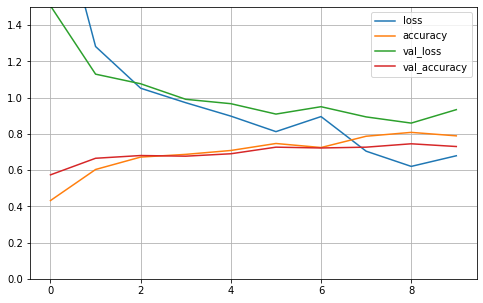

In [242]:
# Plot learning curves for model
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1.5) # set the vertical range to [0-1]
# plt.savefig("figures/learning_curves_model_3", tight_layout=False)
plt.show()

In [243]:
history_dict = history.history.copy()
# history_dict['train_accuracy'] = history_dict.pop('accuracy') # rename the the key to 'test_accuracy'
history_df=pd.DataFrame(history_dict)

In [244]:
results_df3 = history_df.iloc[-1:].copy()
results_df3.insert(0,'model','LSTM RNN baseline') # want the model name to appear first
results_df3['test_accuracy'] = test_accuracy
results_df3['test_loss'] = test_loss
results_df3['training time (sec)'] = train_time      # we are okay with training time appearing last
results_df3['testing time (sec)'] = test_time      # we are okay with training time appearing last
results_df3

,model,loss,accuracy,val_loss,val_accuracy,test_accuracy,test_loss,training time (sec),testing time (sec)
9,LSTM RNN baseline,0.679019,0.788929,0.933482,0.730018,0.731102,0.934732,83.972107,0.956484


## 3.2 LSTM RNN w/100 memory cell units

In [245]:
model_3a = Sequential()
model_3a.add(Embedding(input_dim = voc_size, output_dim = 64, input_length = 193))
model_3a.add(LSTM(units = 100))
model_3a.add(Dense(units = 21, activation='softmax'))


model_3a.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 193, 64)           640000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               66000     
_________________________________________________________________
dense_1 (Dense)              (None, 21)                2121      
Total params: 708,121
Trainable params: 708,121
Non-trainable params: 0
_________________________________________________________________


In [246]:
model_3a.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### 3.2.a Model Training

In [247]:
train_rt = TrainRuntimeCallback()
history = model_3a.fit(train_data_sm_rnn,
                    one_hot_train_labels_sm,
                    callbacks = [train_rt],
                    epochs=10,
                    batch_size=100,
#                   validation_data=(val_data_sm_rnn, one_hot_val_labels_sm))
                    validation_split = 0.15)   # comment out if setting validation_data value.

# Saving models locally after fitting
# save_dir = "results/"
# model_name = 'Reuters_3a.h5'
# model_path = os.path.join(save_dir, model_name)
# model_3a.save(model_path)
# print('Saved trained model at %s ' % model_path)
# print('--------------------------')

Epoch 1/10
64/64 [==============================] - 26s 413ms/step - loss: 1.9544 - accuracy: 0.4162 - val_loss: 1.6460 - val_accuracy: 0.4103
Epoch 2/10
64/64 [==============================] - 26s 404ms/step - loss: 1.4303 - accuracy: 0.5467 - val_loss: 1.3287 - val_accuracy: 0.5915
Epoch 3/10
64/64 [==============================] - 26s 411ms/step - loss: 1.2020 - accuracy: 0.6139 - val_loss: 1.0957 - val_accuracy: 0.6545
Epoch 4/10
64/64 [==============================] - 26s 406ms/step - loss: 1.0093 - accuracy: 0.6680 - val_loss: 1.1604 - val_accuracy: 0.6385
Epoch 5/10
64/64 [==============================] - 26s 406ms/step - loss: 0.8890 - accuracy: 0.7024 - val_loss: 0.8941 - val_accuracy: 0.7167
Epoch 6/10
64/64 [==============================] - 26s 403ms/step - loss: 0.7301 - accuracy: 0.7642 - val_loss: 0.9064 - val_accuracy: 0.7185
Epoch 7/10
64/64 [==============================] - 26s 401ms/step - loss: 0.6432 - accuracy: 0.7916 - val_loss: 0.8656 - val_accuracy: 0.7362

In [248]:
# Get the training time
train_time = train_rt.process_time
train_time # in seconds

264.753821

In [249]:
print(f"train_acc: {history.history['accuracy'][-1]}, val_acc: {history.history['val_accuracy'][-1]}")

train_acc: 0.891014575958252, val_acc: 0.7735346555709839


### 3.2.b Model Testing

In [250]:
test_rt = TestRuntimeCallback()
test_loss, test_accuracy = model_3a.evaluate(test_data_sm_rnn, one_hot_test_labels_sm, callbacks=[test_rt], verbose=0)
print(f"test_accuracy={test_accuracy}, test_loss={test_loss}")

test_accuracy=0.752159833908081, test_loss=0.9204900860786438


In [251]:
# Get the test time
test_time = test_rt.process_time
test_time # in seconds

2.005659

### 3.2.c Model Performance

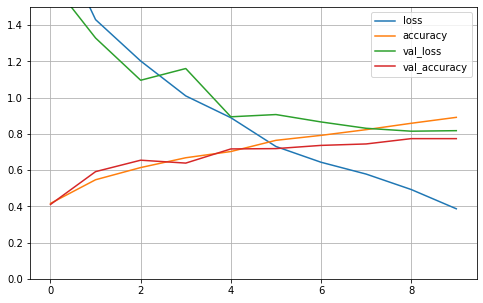

In [252]:
# Plot learning curves for model
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1.5) # set the vertical range to [0-1]
# plt.savefig("figures/learning_curves_model_3a", tight_layout=False)
plt.show()

In [253]:
history_dict = history.history.copy()
# history_dict['train_accuracy'] = history_dict.pop('accuracy') # rename the the key to 'test_accuracy'
history_df=pd.DataFrame(history_dict)

In [254]:
results_df3a = history_df.iloc[-1:].copy()
results_df3a.insert(0,'model','LSTM RNN (100 memory cell units)') # want the model name to appear first
results_df3a['test_accuracy'] = test_accuracy
results_df3a['test_loss'] = test_loss
results_df3a['training time (sec)'] = train_time      
results_df3a['testing time (sec)'] = test_time      
results_df3a

,model,loss,accuracy,val_loss,val_accuracy,test_accuracy,test_loss,training time (sec),testing time (sec)
9,LSTM RNN (100 memory cell units),0.386419,0.891015,0.817529,0.773535,0.75216,0.92049,264.753821,2.005659


## 3.3 LSTM RNN w/20% dropout

In [255]:
model_3b = Sequential()
model_3b.add(Embedding(input_dim = voc_size, output_dim = 64, input_length = 193))
# model_3b.add(layers.SpatialDropout1D(0.2))
model_3b.add(LSTM(units=100))
model_3b.add(layers.Dropout(0.2))
model_3b.add(Dense(units = 21, activation='softmax'))

model_3b.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 193, 64)           640000    
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               66000     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 21)                2121      
Total params: 708,121
Trainable params: 708,121
Non-trainable params: 0
_________________________________________________________________


In [256]:
model_3b.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### 3.3.a Model Training

In [257]:
train_rt = TrainRuntimeCallback()
history = model_3b.fit(train_data_sm_rnn,
                    one_hot_train_labels_sm,
                    callbacks = [train_rt],
                    epochs=10,
                    batch_size=100,
#                   validation_data=(val_data_sm_rnn, one_hot_val_labels_sm))
                    validation_split = 0.15)   # comment out if setting validation_data value.

# Saving models locally after fitting
# save_dir = "results/"
# model_name = 'Reuters_3b.h5'
# model_path = os.path.join(save_dir, model_name)
# model_3b.save(model_path)
# print('Saved trained model at %s ' % model_path)
# print('--------------------------')

Epoch 1/10
64/64 [==============================] - 26s 412ms/step - loss: 1.9840 - accuracy: 0.4052 - val_loss: 1.6191 - val_accuracy: 0.4103
Epoch 2/10
64/64 [==============================] - 26s 400ms/step - loss: 1.3550 - accuracy: 0.5590 - val_loss: 1.1852 - val_accuracy: 0.5977
Epoch 3/10
64/64 [==============================] - 29s 460ms/step - loss: 1.0985 - accuracy: 0.6255 - val_loss: 1.0310 - val_accuracy: 0.6545
Epoch 4/10
64/64 [==============================] - 26s 403ms/step - loss: 0.9658 - accuracy: 0.6666 - val_loss: 0.9923 - val_accuracy: 0.6616
Epoch 5/10
64/64 [==============================] - 26s 412ms/step - loss: 0.8856 - accuracy: 0.6878 - val_loss: 1.1065 - val_accuracy: 0.6252
Epoch 6/10
64/64 [==============================] - 26s 412ms/step - loss: 0.8236 - accuracy: 0.7077 - val_loss: 0.9540 - val_accuracy: 0.6909
Epoch 7/10
64/64 [==============================] - 26s 401ms/step - loss: 0.7445 - accuracy: 0.7453 - val_loss: 0.8961 - val_accuracy: 0.7220

In [258]:
# Get the training time
train_time = train_rt.process_time
train_time # in seconds

268.786401

In [259]:
print(f"train_acc: {history.history['accuracy'][-1]}, val_acc: {history.history['val_accuracy'][-1]}")

train_acc: 0.841775119304657, val_acc: 0.7406749725341797


### 3.3.b Model Testing

In [260]:
test_rt = TestRuntimeCallback()
test_loss, test_accuracy = model_3b.evaluate(test_data_sm_rnn, one_hot_test_labels_sm, callbacks=[test_rt], verbose=0)
print(f"test_accuracy={test_accuracy}, test_loss={test_loss}")

test_accuracy=0.7510799169540405, test_loss=0.8872067928314209


In [261]:
# Get the test time
test_time = test_rt.process_time
test_time # in seconds

2.041616

### 3.3.c Model Performance

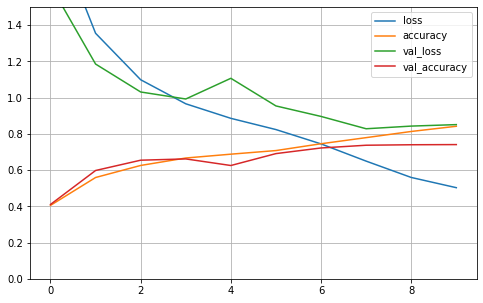

In [262]:
# Plot learning curves for model
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1.5) # set the vertical range to [0-1]
# plt.savefig("figures/learning_curves_model_3b", tight_layout=False)
plt.show()

In [263]:
history_dict = history.history.copy()
# history_dict['train_accuracy'] = history_dict.pop('accuracy') # rename the the key to 'test_accuracy'
history_df=pd.DataFrame(history_dict)

In [264]:
results_df3b = history_df.iloc[-1:].copy()
results_df3b.insert(0,'model','LSTM RNN with Drop') # want the model name to appear first
results_df3b['test_accuracy'] = test_accuracy
results_df3b['test_loss'] = test_loss
results_df3b['training time (sec)'] = train_time      
results_df3b['testing time (sec)'] = test_time     
results_df3b

,model,loss,accuracy,val_loss,val_accuracy,test_accuracy,test_loss,training time (sec),testing time (sec)
9,LSTM RNN with Drop,0.502862,0.841775,0.850915,0.740675,0.75108,0.887207,268.786401,2.041616


# 4. Experiment 4: CNN

In [265]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

## 4.1 1D CNN

In [266]:
model_4 = Sequential()
model_4.add(Embedding(input_dim = voc_size, output_dim = 64, input_length=193))
model_4.add(Conv1D(filters = 32, kernel_size = 3, activation='relu')) 
model_4.add(Flatten())
model_4.add(Dense(units = 512, activation='relu')) 
# model_4.add(layers.Dropout(0.5)) 
model_4.add(Dense(units = 21, activation='softmax'))

model_4.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 193, 64)           640000    
_________________________________________________________________
conv1d (Conv1D)              (None, 191, 32)           6176      
_________________________________________________________________
flatten (Flatten)            (None, 6112)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               3129856   
_________________________________________________________________
dense_1 (Dense)              (None, 21)                10773     
Total params: 3,786,805
Trainable params: 3,786,805
Non-trainable params: 0
_________________________________________________________________


In [267]:
model_4.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### 4.1.a Model Training

In [268]:
train_rt = TrainRuntimeCallback()
history = model_4.fit(train_data_sm_rnn, one_hot_train_labels_sm,
                    callbacks = [train_rt],
                    epochs=10,
                    batch_size=100,
                    validation_split=0.15)

# Saving models locally after fitting
# save_dir = "results/"
# model_name = 'Reuters_4.h5'
# model_path = os.path.join(save_dir, model_name)
# model_4.save(model_path)
# print('Saved trained model at %s ' % model_path)
# print('--------------------------')

Epoch 1/10
64/64 [==============================] - 6s 90ms/step - loss: 1.3611 - accuracy: 0.5594 - val_loss: 0.9962 - val_accuracy: 0.6892
Epoch 2/10
64/64 [==============================] - 6s 89ms/step - loss: 0.7253 - accuracy: 0.7823 - val_loss: 0.7144 - val_accuracy: 0.7931
Epoch 3/10
64/64 [==============================] - 6s 89ms/step - loss: 0.3560 - accuracy: 0.9070 - val_loss: 0.6605 - val_accuracy: 0.8277
Epoch 4/10
64/64 [==============================] - 6s 89ms/step - loss: 0.1913 - accuracy: 0.9564 - val_loss: 0.7141 - val_accuracy: 0.8295
Epoch 5/10
64/64 [==============================] - 6s 88ms/step - loss: 0.1382 - accuracy: 0.9638 - val_loss: 0.6882 - val_accuracy: 0.8419
Epoch 6/10
64/64 [==============================] - 6s 89ms/step - loss: 0.1190 - accuracy: 0.9666 - val_loss: 0.7280 - val_accuracy: 0.8304
Epoch 7/10
64/64 [==============================] - 6s 89ms/step - loss: 0.1079 - accuracy: 0.9680 - val_loss: 0.7719 - val_accuracy: 0.8268
Epoch 8/10
64

In [269]:
# Get the training time
train_time = train_rt.process_time
train_time # in seconds

58.347607

In [270]:
print(f"train_acc: {history.history['accuracy'][-1]}, val_acc: {history.history['val_accuracy'][-1]}")

train_acc: 0.967225968837738, val_acc: 0.8206039071083069


### 4.1.b Model Testing

In [271]:
test_rt = TestRuntimeCallback()
test_loss, test_accuracy = model_4.evaluate(test_data_sm_rnn, one_hot_test_labels_sm, callbacks=[test_rt], verbose=0)
print(f"test_accuracy={test_accuracy}, test_loss={test_loss}")

test_accuracy=0.8245140314102173, test_loss=0.783259391784668


In [272]:
# Get the test time
test_time = test_rt.process_time
test_time # in seconds

0.553103

### 4.1.c Model Performance

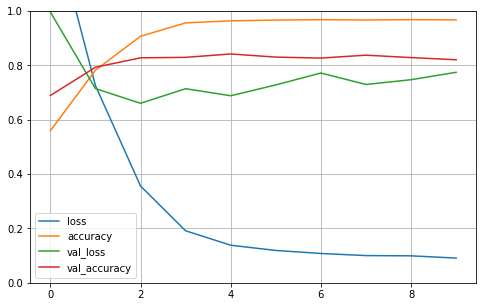

In [273]:
# Plot learning curves for model
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
# plt.savefig("figures/learning_curves_model_4", tight_layout=False)
plt.show()

In [274]:
history_dict = history.history.copy()
# history_dict['train_accuracy'] = history_dict.pop('accuracy') # rename the the key to 'test_accuracy'
history_df=pd.DataFrame(history_dict)

In [275]:
results_df4 = history_df.iloc[-1:].copy()
results_df4.insert(0,'model','1D CNN baseline') # want the model name to appear first
results_df4['test_accuracy'] = test_accuracy
results_df4['test_loss'] = test_loss
results_df4['training time (sec)'] = train_time      
results_df4['testing time (sec)'] = test_time      
results_df4

,model,loss,accuracy,val_loss,val_accuracy,test_accuracy,test_loss,training time (sec),testing time (sec)
9,1D CNN baseline,0.090988,0.967226,0.774481,0.820604,0.824514,0.783259,58.347607,0.553103


## 4.2 1D CNN w/50% dropout

In [276]:
model_4a = Sequential()
model_4a.add(Embedding(input_dim = voc_size, output_dim = 64, input_length=193))
model_4a.add(Conv1D(filters = 32, kernel_size = 3, activation='relu')) 
model_4a.add(Flatten())
model_4a.add(Dense(units = 512, activation='relu')) 
model_4a.add(layers.Dropout(0.5)) 
model_4a.add(Dense(units = 21, activation='softmax'))

model_4a.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 193, 64)           640000    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 191, 32)           6176      
_________________________________________________________________
flatten_1 (Flatten)          (None, 6112)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               3129856   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 21)                10773     
Total params: 3,786,805
Trainable params: 3,786,805
Non-trainable params: 0
____________________________________________

In [277]:
model_4a.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### 4.2.a Model Training

In [278]:
train_rt = TrainRuntimeCallback()
history = model_4a.fit(train_data_sm_rnn, one_hot_train_labels_sm,
                    callbacks = [train_rt],
                    epochs=10,
                    batch_size=100,
                    validation_split=0.15)

# Saving models locally after fitting
# save_dir = "results/"
# model_name = 'Reuters_4a.h5'
# model_path = os.path.join(save_dir, model_name)
# model_4a.save(model_path)
# print('Saved trained model at %s ' % model_path)
# print('--------------------------')

Epoch 1/10
64/64 [==============================] - 6s 93ms/step - loss: 1.4214 - accuracy: 0.5418 - val_loss: 1.0400 - val_accuracy: 0.6314
Epoch 2/10
64/64 [==============================] - 6s 90ms/step - loss: 0.8435 - accuracy: 0.7265 - val_loss: 0.8023 - val_accuracy: 0.7575
Epoch 3/10
64/64 [==============================] - 6s 90ms/step - loss: 0.5055 - accuracy: 0.8584 - val_loss: 0.6247 - val_accuracy: 0.8295
Epoch 4/10
64/64 [==============================] - 6s 90ms/step - loss: 0.2859 - accuracy: 0.9271 - val_loss: 0.6321 - val_accuracy: 0.8472
Epoch 5/10
64/64 [==============================] - 6s 91ms/step - loss: 0.1825 - accuracy: 0.9537 - val_loss: 0.6687 - val_accuracy: 0.8401
Epoch 6/10
64/64 [==============================] - 6s 91ms/step - loss: 0.1490 - accuracy: 0.9622 - val_loss: 0.7077 - val_accuracy: 0.8410
Epoch 7/10
64/64 [==============================] - 6s 91ms/step - loss: 0.1133 - accuracy: 0.9666 - val_loss: 0.7660 - val_accuracy: 0.8393
Epoch 8/10
64

In [279]:
# Get the training time
train_time = train_rt.process_time
train_time # in seconds

59.383079

In [280]:
print(f"train_acc: {history.history['accuracy'][-1]}, val_acc: {history.history['val_accuracy'][-1]}")

train_acc: 0.969264566898346, val_acc: 0.8374778032302856


### 4.2.b Model Testing

In [281]:
test_rt = TestRuntimeCallback()
test_loss, test_accuracy = model_4a.evaluate(test_data_sm_rnn, one_hot_test_labels_sm, callbacks=[test_rt], verbose=0)
print(f"test_accuracy={test_accuracy}, test_loss={test_loss}")

test_accuracy=0.8353132009506226, test_loss=0.8075375556945801


In [282]:
# Get the test time
test_time = test_rt.process_time
test_time # in seconds

0.538955

### 4.2.c Model Performance

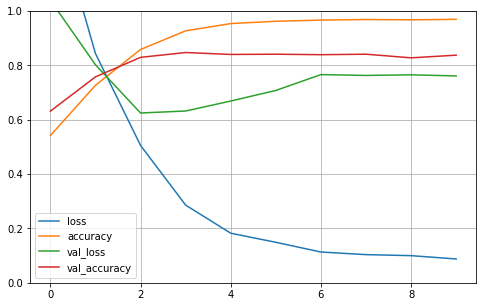

In [283]:
# Plot learning curves for model
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
# plt.savefig("figures/learning_curves_model_4a", tight_layout=False)
plt.show()

In [284]:
history_dict = history.history.copy()
# history_dict['train_accuracy'] = history_dict.pop('accuracy') # rename the the key to 'test_accuracy'
history_df=pd.DataFrame(history_dict)

In [285]:
results_df4a = history_df.iloc[-1:].copy()
results_df4a.insert(0,'model','1D CNN baseline with Drop') # want the model name to appear first
results_df4a['test_accuracy'] = test_accuracy
results_df4a['test_loss'] = test_loss
results_df4a['training time (sec)'] = train_time      
results_df4a['testing time (sec)'] = test_time      
results_df4a

,model,loss,accuracy,val_loss,val_accuracy,test_accuracy,test_loss,training time (sec),testing time (sec)
9,1D CNN baseline with Drop,0.087704,0.969265,0.761162,0.837478,0.835313,0.807538,59.383079,0.538955


## 4.3 1D CNN w/50% dropout and max pooling

In [286]:
model_4b = Sequential()
model_4b.add(Embedding(input_dim = voc_size, output_dim = 64, input_length=193))
model_4b.add(Conv1D(filters = 32, kernel_size = 3, activation='relu')) 
model_4b.add(MaxPooling1D())
model_4b.add(layers.Dropout(0.5))
model_4b.add(Flatten())
model_4b.add(Dense(units = 512, activation='relu')) 
model_4b.add(Dense(units = 21, activation='softmax'))

model_4b.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 193, 64)           640000    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 191, 32)           6176      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 95, 32)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 95, 32)            0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 3040)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               1556992   
_________________________________________________________________
dense_5 (Dense)              (None, 21)               

In [287]:
model_4b.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### 4.3.a Model Training

In [288]:
train_rt = TrainRuntimeCallback()
history = model_4b.fit(train_data_sm_rnn, one_hot_train_labels_sm,
                    callbacks = [train_rt],
                    epochs=10,
                    batch_size=100,
                    validation_split=0.15)

# Saving models locally after fitting
# save_dir = "results/"
# model_name = 'Reuters_4b.h5'
# model_path = os.path.join(save_dir, model_name)
# model_4b.save(model_path)
# print('Saved trained model at %s ' % model_path)
# print('--------------------------')

Epoch 1/10
64/64 [==============================] - 5s 82ms/step - loss: 1.4466 - accuracy: 0.5329 - val_loss: 1.1112 - val_accuracy: 0.6288
Epoch 2/10
64/64 [==============================] - 5s 79ms/step - loss: 0.8994 - accuracy: 0.7069 - val_loss: 0.8430 - val_accuracy: 0.7371
Epoch 3/10
64/64 [==============================] - 5s 79ms/step - loss: 0.5707 - accuracy: 0.8352 - val_loss: 0.6537 - val_accuracy: 0.8171
Epoch 4/10
64/64 [==============================] - 5s 80ms/step - loss: 0.3330 - accuracy: 0.9106 - val_loss: 0.6547 - val_accuracy: 0.8313
Epoch 5/10
64/64 [==============================] - 5s 80ms/step - loss: 0.2252 - accuracy: 0.9434 - val_loss: 0.6642 - val_accuracy: 0.8401
Epoch 6/10
64/64 [==============================] - 5s 81ms/step - loss: 0.1661 - accuracy: 0.9566 - val_loss: 0.7326 - val_accuracy: 0.8384
Epoch 7/10
64/64 [==============================] - 5s 85ms/step - loss: 0.1486 - accuracy: 0.9603 - val_loss: 0.7379 - val_accuracy: 0.8410
Epoch 8/10
64

In [289]:
# Get the training time
train_time = train_rt.process_time
train_time # in seconds

53.300984

In [290]:
print(f"train_acc: {history.history['accuracy'][-1]}, val_acc: {history.history['val_accuracy'][-1]}")

train_acc: 0.9664419293403625, val_acc: 0.8330373167991638


### 4.3.b Model Testing

In [291]:
test_rt = TestRuntimeCallback()
test_loss, test_accuracy = model_4b.evaluate(test_data_sm_rnn, one_hot_test_labels_sm, callbacks=[test_rt], verbose=0)
print(f"test_accuracy={test_accuracy}, test_loss={test_loss}")

test_accuracy=0.8347732424736023, test_loss=0.783611536026001


In [292]:
# Get the test time
test_time = test_rt.process_time
test_time # in seconds

0.395239

### 4.3.c Model Performance

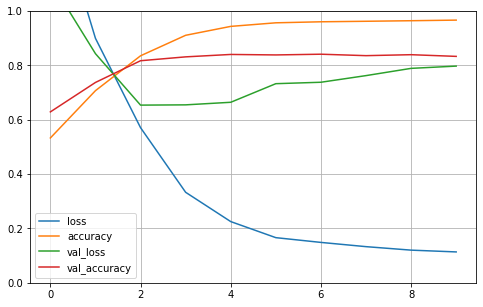

In [293]:
# Plot learning curves for model
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
# plt.savefig("figures/learning_curves_model_4b", tight_layout=False)
plt.show()

In [294]:
history_dict = history.history.copy()
# history_dict['train_accuracy'] = history_dict.pop('accuracy') # rename the the key to 'test_accuracy'
history_df=pd.DataFrame(history_dict)

In [295]:
results_df4b = history_df.iloc[-1:].copy()
results_df4b.insert(0,'model','1D CNN with Drop and max pooling') # want the model name to appear first
results_df4b['test_accuracy'] = test_accuracy
results_df4b['test_loss'] = test_loss
results_df4b['training time (sec)'] = train_time      # we are okay with training time appearing last
results_df4b['testing time (sec)'] = test_time      # we are okay with training time appearing last
results_df4b

,model,loss,accuracy,val_loss,val_accuracy,test_accuracy,test_loss,training time (sec),testing time (sec)
9,1D CNN with Drop and max pooling,0.113593,0.966442,0.797259,0.833037,0.834773,0.783612,53.300984,0.395239


## 5. Summary of Experiment Results


In [296]:
results_df4=results_df4.append(results_df4a,ignore_index=True)
results_df4=results_df4.append(results_df4b,ignore_index=True)
results_df4

,model,loss,accuracy,val_loss,val_accuracy,test_accuracy,test_loss,training time (sec),testing time (sec)
0,1D CNN baseline,0.090988,0.967226,0.774481,0.820604,0.824514,0.783259,58.347607,0.553103
1,1D CNN baseline with Drop,0.087704,0.969265,0.761162,0.837478,0.835313,0.807538,59.383079,0.538955
2,1D CNN with Drop and max pooling,0.113593,0.966442,0.797259,0.833037,0.834773,0.783612,53.300984,0.395239


In [297]:
results_df4.to_pickle("results4.pkl") 

In [298]:
frames = [results_df, results_df2, results_df3, results_df4]

df_final = pd.concat(frames, keys=['Exp 1','Exp 2','Exp 3', 'Exp 4'])

df_final

model  ...  testing time (sec)
Exp 1 0           DNN (2 layers) 9 topics  ...            0.130511
      1            DNN (2 layers 256/256)  ...            0.346137
      2             DNN (2 layers) w Drop  ...            0.148081
      3      DNN (2 layers) w Drop and L1  ...            0.205867
      4            DNN (2 layers) w Embed  ...            0.253090
      5  DNN (2 layers) w Embed + Dropout  ...            0.248716
Exp 2 0             Simple RNN (64 units)  ...            0.751699
      1            Simple RNN (100 units)  ...            0.966891
      2   Simple RNN (32 units w/dropout)  ...            0.661645
Exp 3 9                 LSTM RNN baseline  ...            0.956484
Exp 4 0                   1D CNN baseline  ...            0.553103
      1         1D CNN baseline with Drop  ...            0.538955
      2  1D CNN with Drop and max pooling  ...            0.395239

[13 rows x 9 columns]